#### Question

Run Aaboost and GB on the given data and compare. Explain your results.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Creditability       1000 non-null   int64 
 1   Acc_Bal_bin         1000 non-null   object
 2   Pay_Status_bin      1000 non-null   object
 3   Value_SavStock_bin  1000 non-null   object
 4   Length_Emp_bin      1000 non-null   object
 5   S&M_Status_bin      1000 non-null   object
 6   No_of_Credits_bin   1000 non-null   object
 7   Co_Credits_bin      1000 non-null   object
 8   Purpose_bin         1000 non-null   object
 9   Telephone_bin       1000 non-null   object
 10  Instalment_bin      1000 non-null   object
 11  Apartment_bin       1000 non-null   object
 12  Most_Val_Asset_bin  1000 non-null   object
 13  Duration_Credit     1000 non-null   int64 
 14  Credit_Amount       1000 non-null   int64 
 15  Age_bin             1000 non-null   object
dtypes: int64(3), object(13)
m

,count,proportion
Creditability,,
1,700,0.7
0,300,0.3


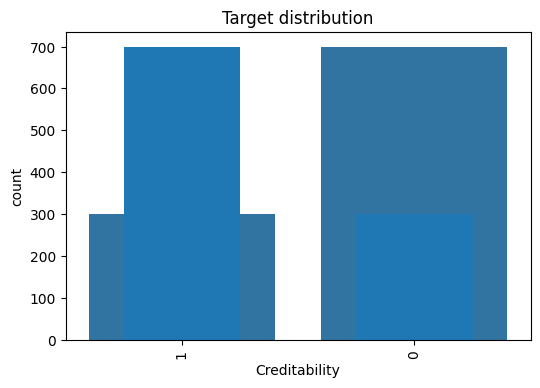

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_score
from numpy import mean, std
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

df = pd.read_csv('german_data_creditcard.csv')

print(df.info())
plt.figure(figsize=(6, 4))
sns.countplot(x='Creditability', data=df)

counts = df['Creditability'].value_counts()
proportions = df['Creditability'].value_counts(normalize=True)

display(pd.DataFrame({"count": counts, "proportion": proportions}))

counts.plot(kind="bar", title="Target distribution")
plt.show()

Pre-processing

In [8]:
df_encode = pd.get_dummies(df, drop_first=True)
print(df_encode.head())

   Creditability  Duration_Credit  Credit_Amount  Acc_Bal_bin_b. no balance  \
0              1               18           1049                      False   
1              1                9           2799                      False   
2              1               12            841                       True   
3              1               12           2122                      False   
4              1               12           2171                      False   

   Acc_Bal_bin_c. some balance  Pay_Status_bin_b. paid up  \
0                        False                      False   
1                        False                      False   
2                        False                       True   
3                        False                      False   
4                        False                      False   

   Pay_Status_bin_c. no problem  Value_SavStock_bin_b. >= 100 DM  \
0                          True                            False   
1                     

Split the data into train and test sets

In [9]:
# features and target

X = df_encode.drop('Creditability', axis=1)

y = df_encode['Creditability']


# train and test sets

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=0.7,
    random_state=42,
    stratify=y
)

print(X_train.shape, X_test.shape)

(700, 21) (300, 21)


### Train the model

##### **AdaBoost**

In [11]:

model = AdaBoostClassifier(random_state=1)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

n_scores = cross_val_score(
    model,
    X,
    y,
    scoring='precision',
    cv=cv,
    n_jobs=-1,
    error_score='raise'
)

print('CV Precision: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))


model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

CV Precision: 0.787 (0.026)
              precision    recall  f1-score   support

           0       0.65      0.49      0.56        90
           1       0.80      0.89      0.84       210

    accuracy                           0.77       300
   macro avg       0.72      0.69      0.70       300
weighted avg       0.76      0.77      0.76       300



##### **Gradient Boosting**

In [12]:
gb_model = GradientBoostingClassifier(random_state=42)

# Cross-validation (precision)
cv_scores = cross_val_score(gb_model, X, y, scoring="precision", cv=cv, n_jobs=-1)

print("CV Precision: %.3f (%.3f)" % (np.mean(cv_scores), np.std(cv_scores)))

gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_test)

print(classification_report(y_test, y_pred_gb))

CV Precision: 0.798 (0.028)
              precision    recall  f1-score   support

           0       0.69      0.52      0.59        90
           1       0.81      0.90      0.86       210

    accuracy                           0.79       300
   macro avg       0.75      0.71      0.73       300
weighted avg       0.78      0.79      0.78       300



#### Comparison

In [33]:
print("Confusion Matrix for Adaboost:\n", confusion_matrix(y_test, y_pred))
print("\nConfusion Matrix for Gradient Boosting:\n", confusion_matrix(y_test, y_pred_gb))

precision_ab = precision_score(y_test, y_pred)
print("\nPrecision Score for AdaBoost:", precision_ab)
precision_gb = precision_score(y_test, y_pred_gb)
print("\nPrecision Score for Gradient Boosting:", precision_gb)

Confusion Matrix for Adaboost:
 [[ 44  46]
 [ 24 186]]

Confusion Matrix for Gradient Boosting:
 [[ 47  43]
 [ 21 189]]

Precision Score for AdaBoost: 0.8017241379310345

Precision Score for Gradient Boosting: 0.8146551724137931


- From the precision scores and confusion matrices, we can see that Gradient Boosting provides slightly higher precision which is because it optimizes loss function directly.

- AdaBoost maybe slightly consistant than Gradient Boosting since it has less standard deviation, but the difference is negligibly small

- gradient Boosting has less false positive hence more precise

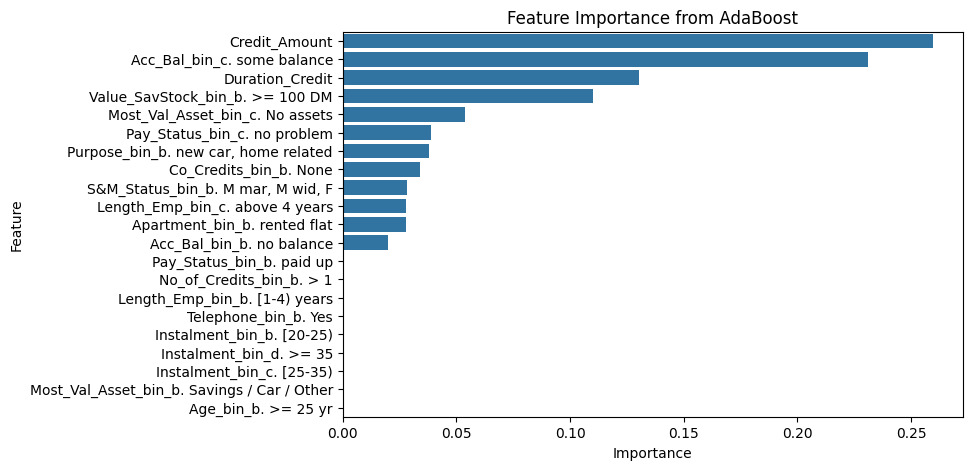

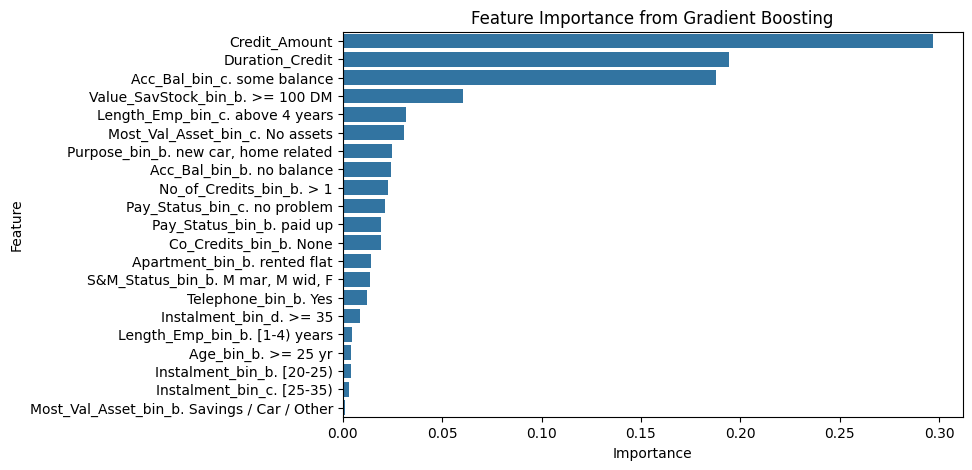

In [18]:
imp_df_ab = pd.DataFrame({
    'Varname': X_train.columns,
    'Imp': model.feature_importances_
})

imp_df_ab = imp_df_ab.sort_values(by='Imp', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x='Imp', y='Varname', data=imp_df_ab)
plt.title('Feature Importance from AdaBoost')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

imp_df_ab = pd.DataFrame({
    'Varname': X_train.columns,
    'Imp': gb_model.feature_importances_
})

imp_df_ab = imp_df_ab.sort_values(by='Imp', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x='Imp', y='Varname', data=imp_df_ab)
plt.title('Feature Importance from Gradient Boosting')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()